# 3D reconstruction of eXtended field of view Light Field Microscopy

## Imports and utility functions

In [6]:
# Load required libraries and define needed functions
import numpy as np
import tifffile
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,20)
import time 
from tqdm import tqdm

def MIP(vol):
    """
    Maximum intensity projection to display a 3D volume in 2D
    """
    vol_size = list(vol.shape)
    x_projection = np.amax(vol, 1)
    y_projection = np.amax(vol, 0)
    z_projection = np.amax(vol, 2)

    out_img = z_projection.min() * np.ones(
        (vol_size[0]+vol_size[2], vol_size[1]+vol_size[2])
    )
    out_img[:vol_size[0], : vol_size[1]] = z_projection
    proj = x_projection
    out_img[:vol_size[0], vol_size[1]:] = proj
    proj = y_projection
    out_img[vol_size[0]:, :vol_size[1]] = proj.transpose(1,0)

    line_color = out_img.max()
    # Draw white lines
    out_img[:, vol_size[1]] = line_color
    out_img[vol_size[0],:] = line_color
    return out_img

def log_likelehood(gt_img, prediction):
    return (prediction - gt_img * np.log(1e-8+prediction)).mean()
def MSE(gt_img, prediction):
    return ((prediction - gt_img)**2).mean()

## Define projection functions and reconstruction methods

In [7]:
def forward(volume, otf, pad_vol):
    # Forward projection of current guess
    curr_volume_padded = np.pad(curr_volume, pad_width=pad_vol, mode='constant', constant_values=0)
    curr_volume_fft = np.fft.rfft2(curr_volume_padded)
    # Forward project by multiplying by the OTF
    curr_img_estimate_fft = curr_volume_fft * otf
    # inverse fft and sum the contributions from all depths
    return np.fft.ifftshift(np.fft.irfft2(curr_img_estimate_fft, s=measured_image.shape).real.sum(0), axes=(-1,-2))

def backward(image, otf_t, pad_vol):
    image_fft = np.fft.rfft2(image)
    volume_fft = image_fft * otf_t
    volume = np.fft.ifftshift(np.fft.irfft2(volume_fft), axes=(-1,-2)).real
    return volume[:,pad_vol[1][0]:-pad_vol[1][1], pad_vol[2][0]:-pad_vol[2][1]]

def compute_volume_update_GD(curr_volume, measured_image, estimated_image, otf_t, pad_vol, learning_rate=0.1):
    diff = estimated_image - measured_image
    # backward project error
    return curr_volume - backward(diff, otf_t, pad_vol) *  learning_rate

def compute_volume_update_MLEM(curr_volume, measured_image, estimated_image, otf_t, pad_vol):
    error_img_space = measured_image / (estimated_image+1e-8)
    # Division by zero might ocure
    error_img_space[np.isinf(error_img_space)] = 0
    error_img_space[np.isnan(error_img_space)] = 0
    error_img_space = error_img_space.clip(0.0,np.median(error_img_space[error_img_space!=0])*10)
    # backward project error
    return curr_volume * backward(error_img_space, otf_t, pad_vol)

## Define parameters for data loading and reconstruction

In [8]:
# Main parameters
data_path = './'
loss_function = 'RL' # 'GD' or 'RL'
n_iterations = 10
img_ix_to_use = 3
percent_depths = 0.5 # Use all the depths? or only a subset, set this to a small number to run fast reconstructions
learning_rate = 0.1 # This is useful for parametrized reconstructions, like gradient descent.

####################### Don't change :) 
# This is related to the camera used for the acquisitions 
dark_current = 100

### Load and pre-process data and PSF

In [9]:
# Load the measurments
xlfm_img = tifffile.imread(f'{data_path}/all_fish_raw_XLFM.tif').astype(np.float32)

# Remove dark current from the camera specs
xlfm_img -= dark_current

# Select one of the images
measured_image = xlfm_img[img_ix_to_use]

# Load the Point Spread Function (PSF)
psf_in = tifffile.imread(f'{data_path}/PSF_corrected_250nm_f16.tif').astype(np.float32)

# Extract subset of depths to use
n_depths = int(psf_in.shape[0]*percent_depths)
depths = [int(d) for d in np.linspace(0, psf_in.shape[0]-1, n_depths)]
psf = psf_in[depths]
# Normalize PSF to sum=1 at every depth
for i in range(psf.shape[0]):
    psf[i] /= psf[i].sum()

# Calculate the required padding for the image and PSF
volume_shape = [n_depths,512,512]
img_shape = measured_image.shape
psf_shape = psf.shape

# Calculate the size of the convolution output
output_shape = (int(img_shape[0] + psf_shape[1]), int(img_shape[1] + psf_shape[2]))
# IMPORTANT: Reduce shape, as the mathematically correct shape is huge, and expensive to work with
output_shape = psf_shape[1:]

# Calculate the required padding for the image and PSF
pad_img = (2*((output_shape[0] - img_shape[0])//2,), 2*((output_shape[1] - img_shape[1])//2,))
pad_psf = ((0,0), 2*((output_shape[0] - psf_shape[1])//2,), 2*((output_shape[1] - psf_shape[2])//2,))
pad_vol = ((0,0), 2*((output_shape[0] - volume_shape[1])//2,), 2*((output_shape[1] - volume_shape[2])//2,))

# Pad the image and PSF with zeros
measured_image_padded = np.pad(measured_image, pad_img, mode='constant')
psf_padded = np.pad(psf, pad_psf, mode='constant')


# Compute the Optical transfer function (OTF)
# This is done to forward / backward project in fourier space, which is much faster than in image space
otf = np.fft.rfft2(psf_padded)
# Compute the complex conjugate of the OTF for the backward projection
otf_t = otf.real - 1j * otf.imag

# Extract the image we want to reconstruct
measured_image = measured_image_padded

## Reconstruct

Recon. iteration:   0%|          | 0/10 [00:00<?, ?it/s]

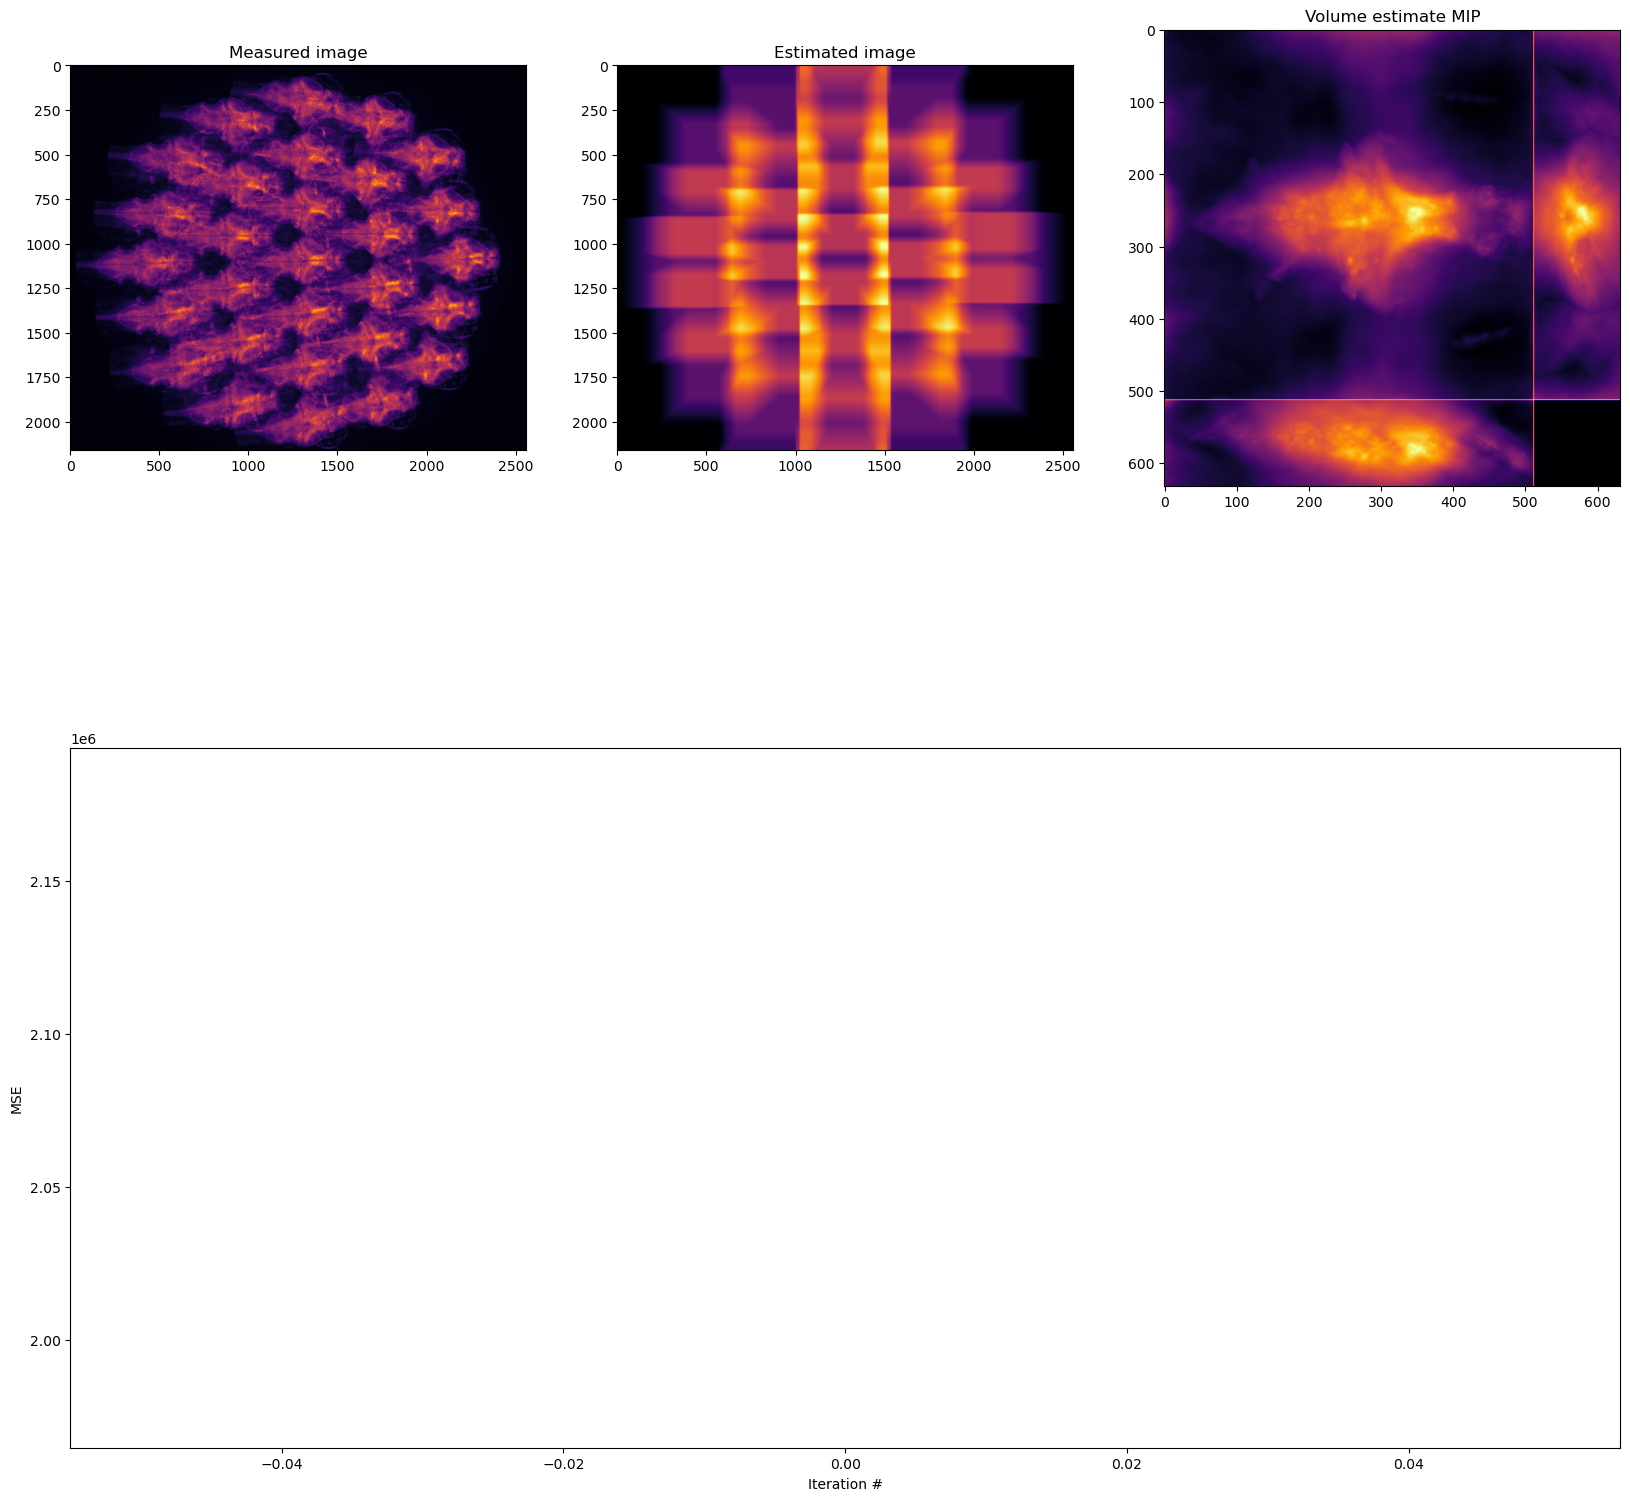

Recon. iteration:  10%|█         | 1/10 [00:29<04:25, 29.48s/it]

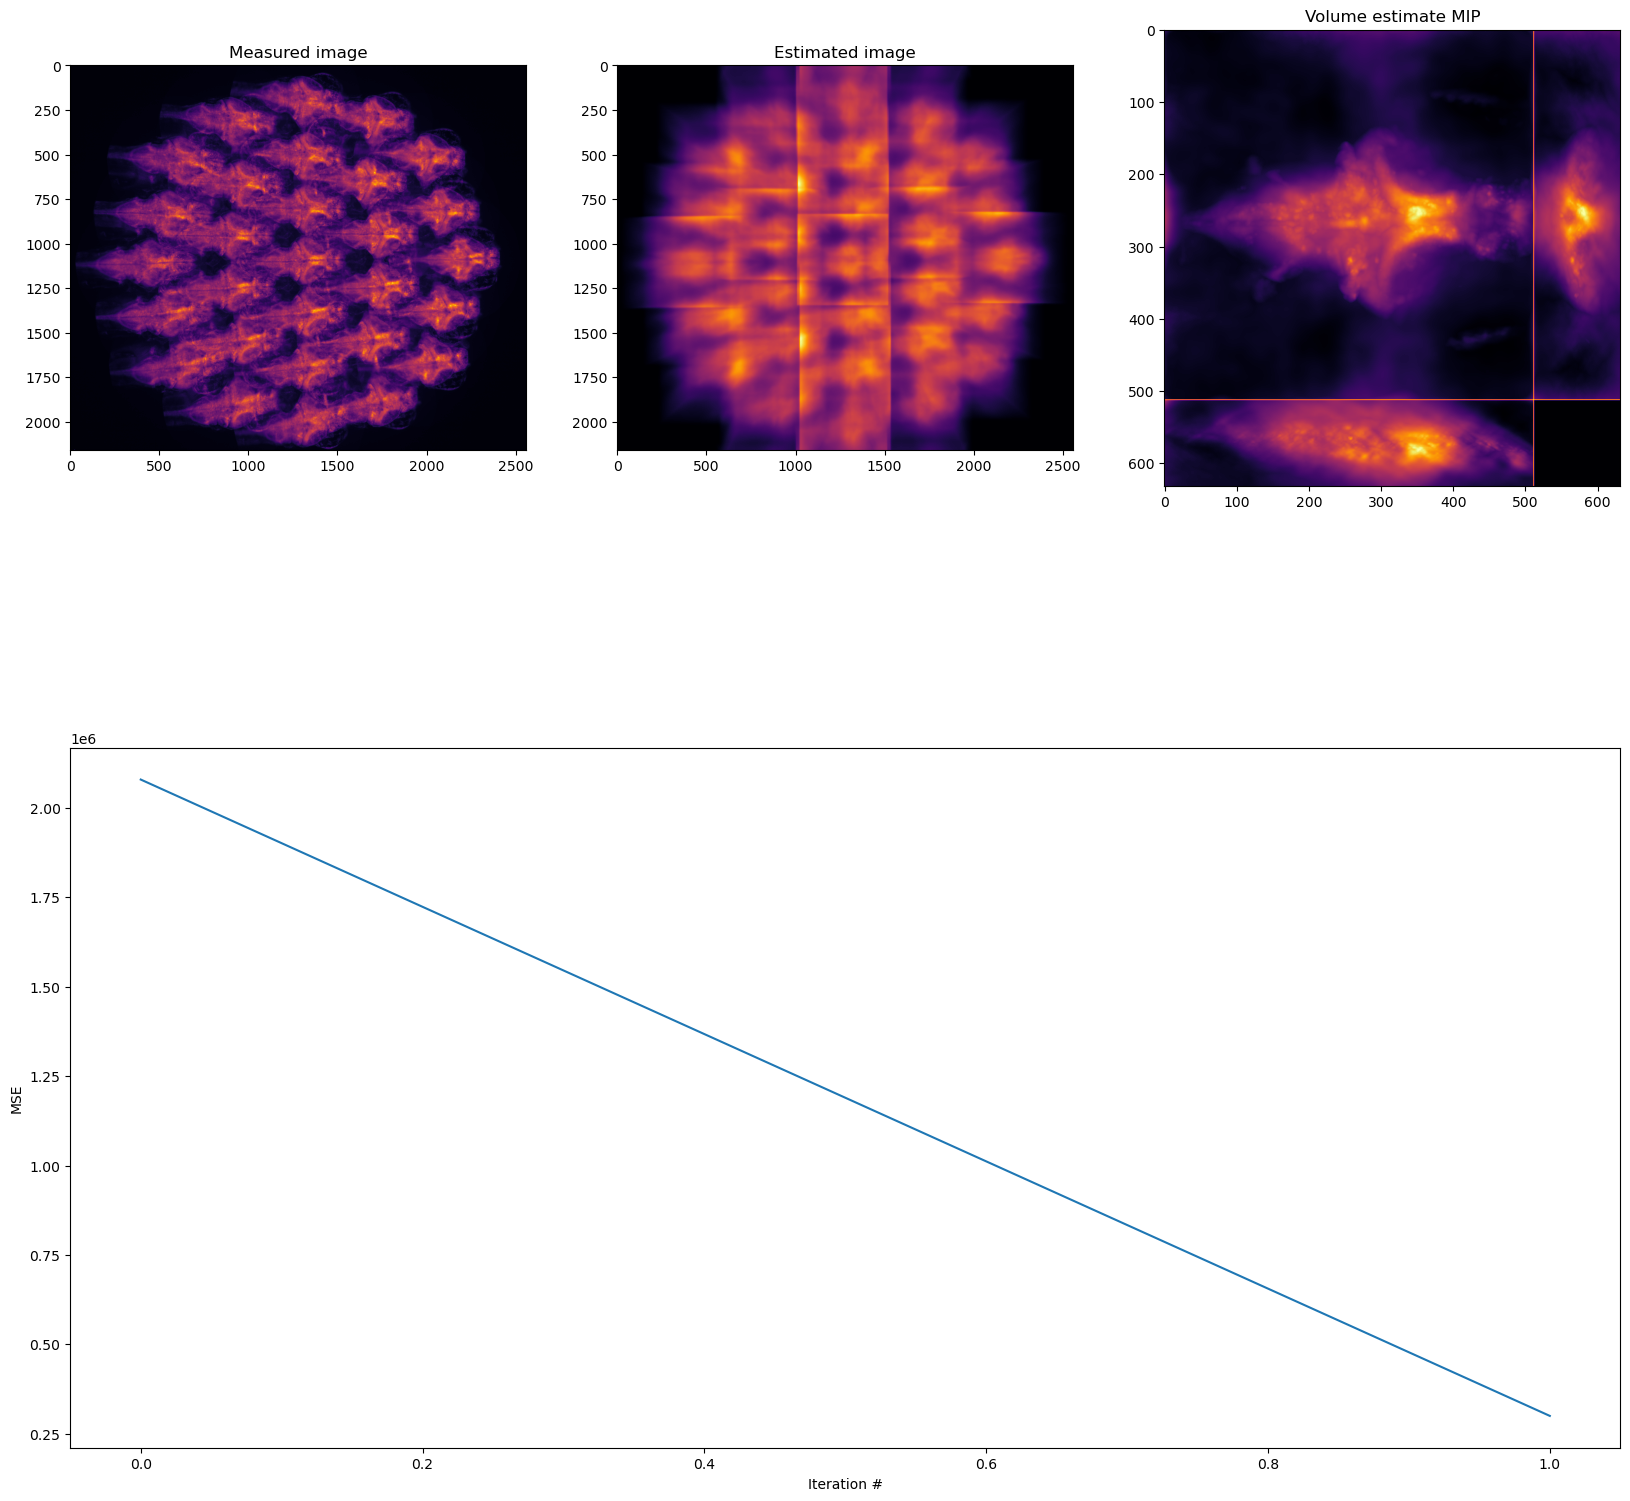

Recon. iteration:  20%|██        | 2/10 [00:58<03:54, 29.34s/it]

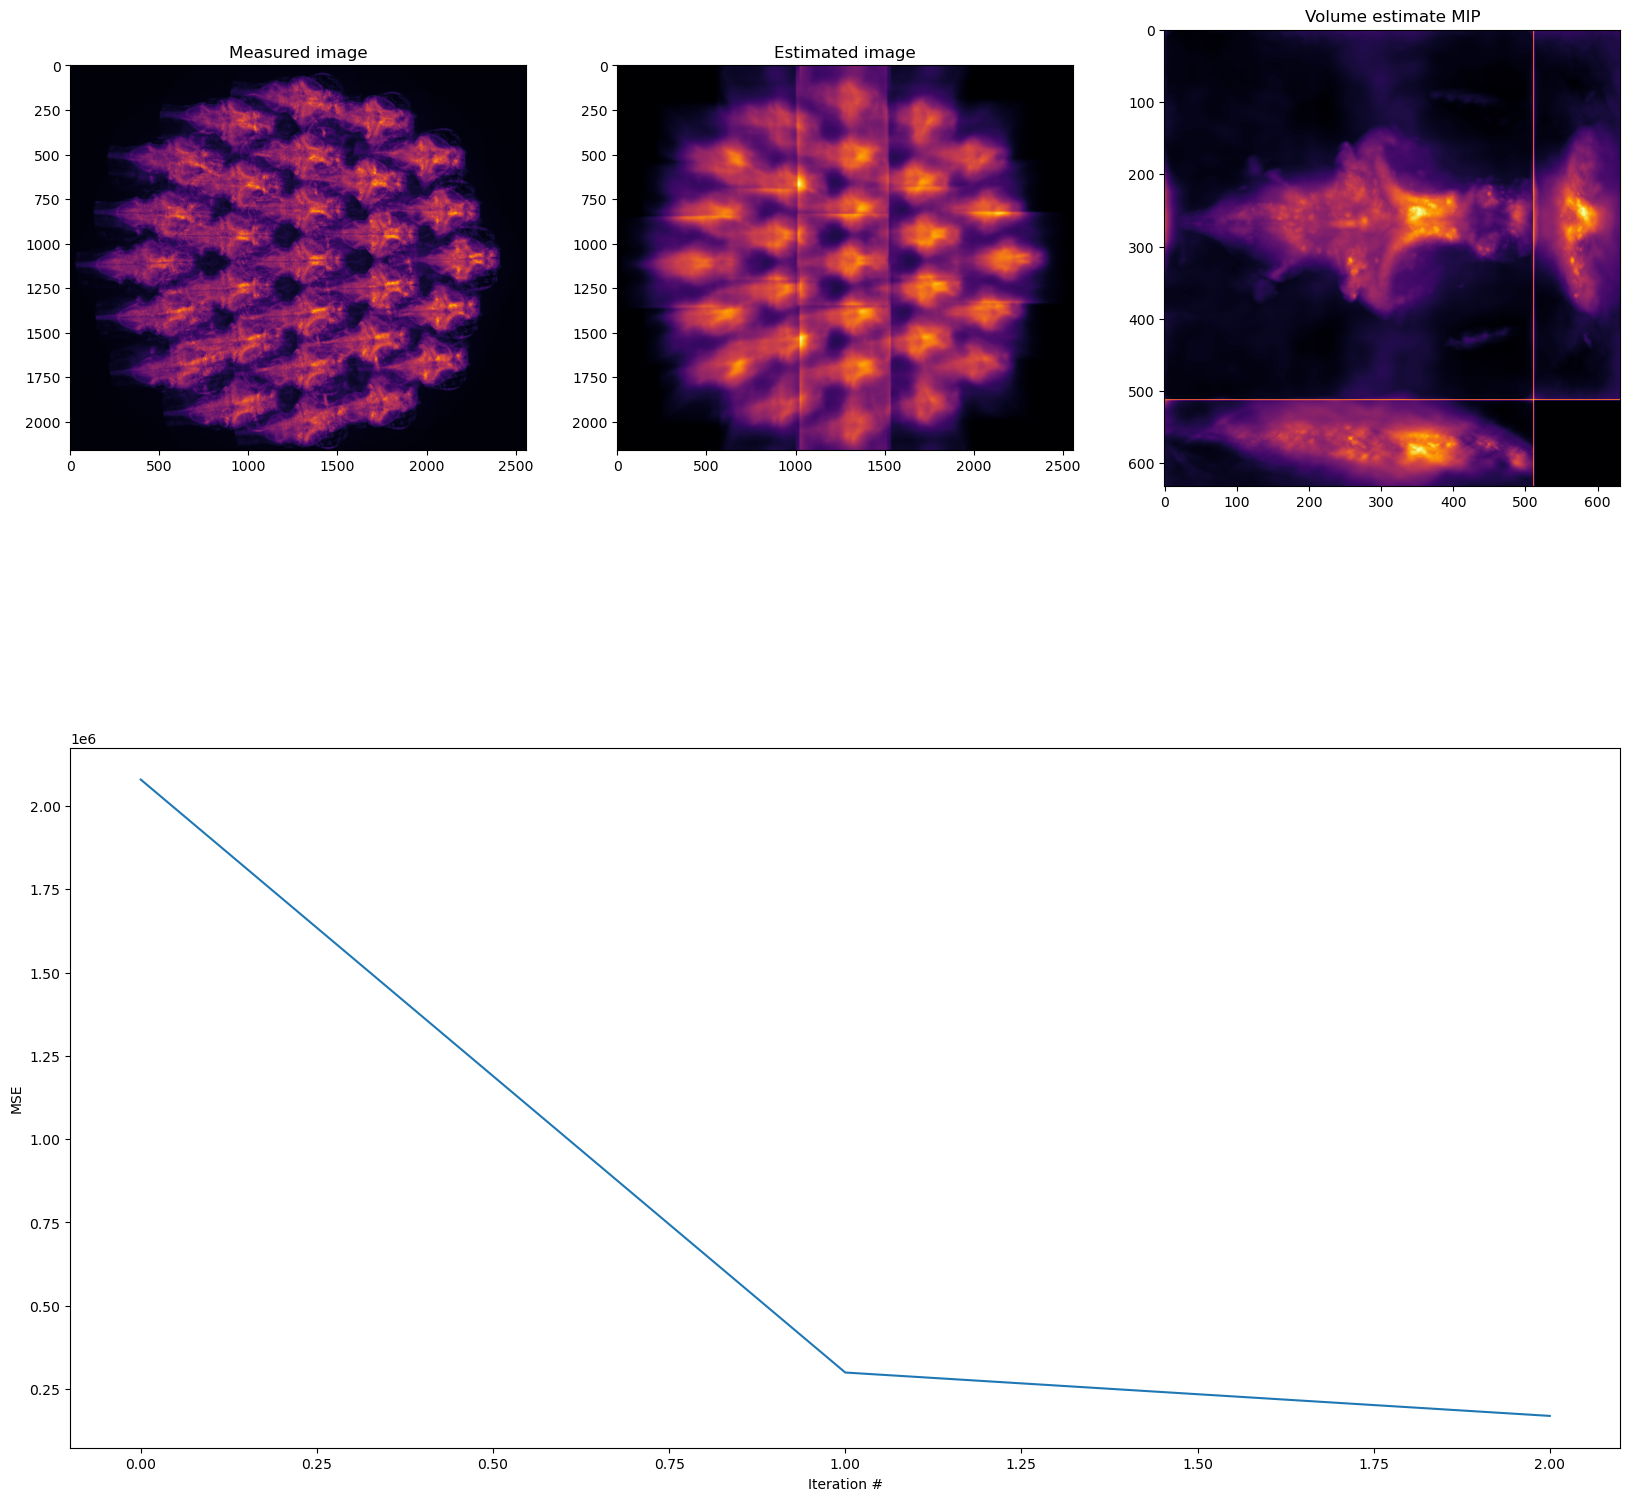

Recon. iteration:  30%|███       | 3/10 [01:28<03:25, 29.38s/it]

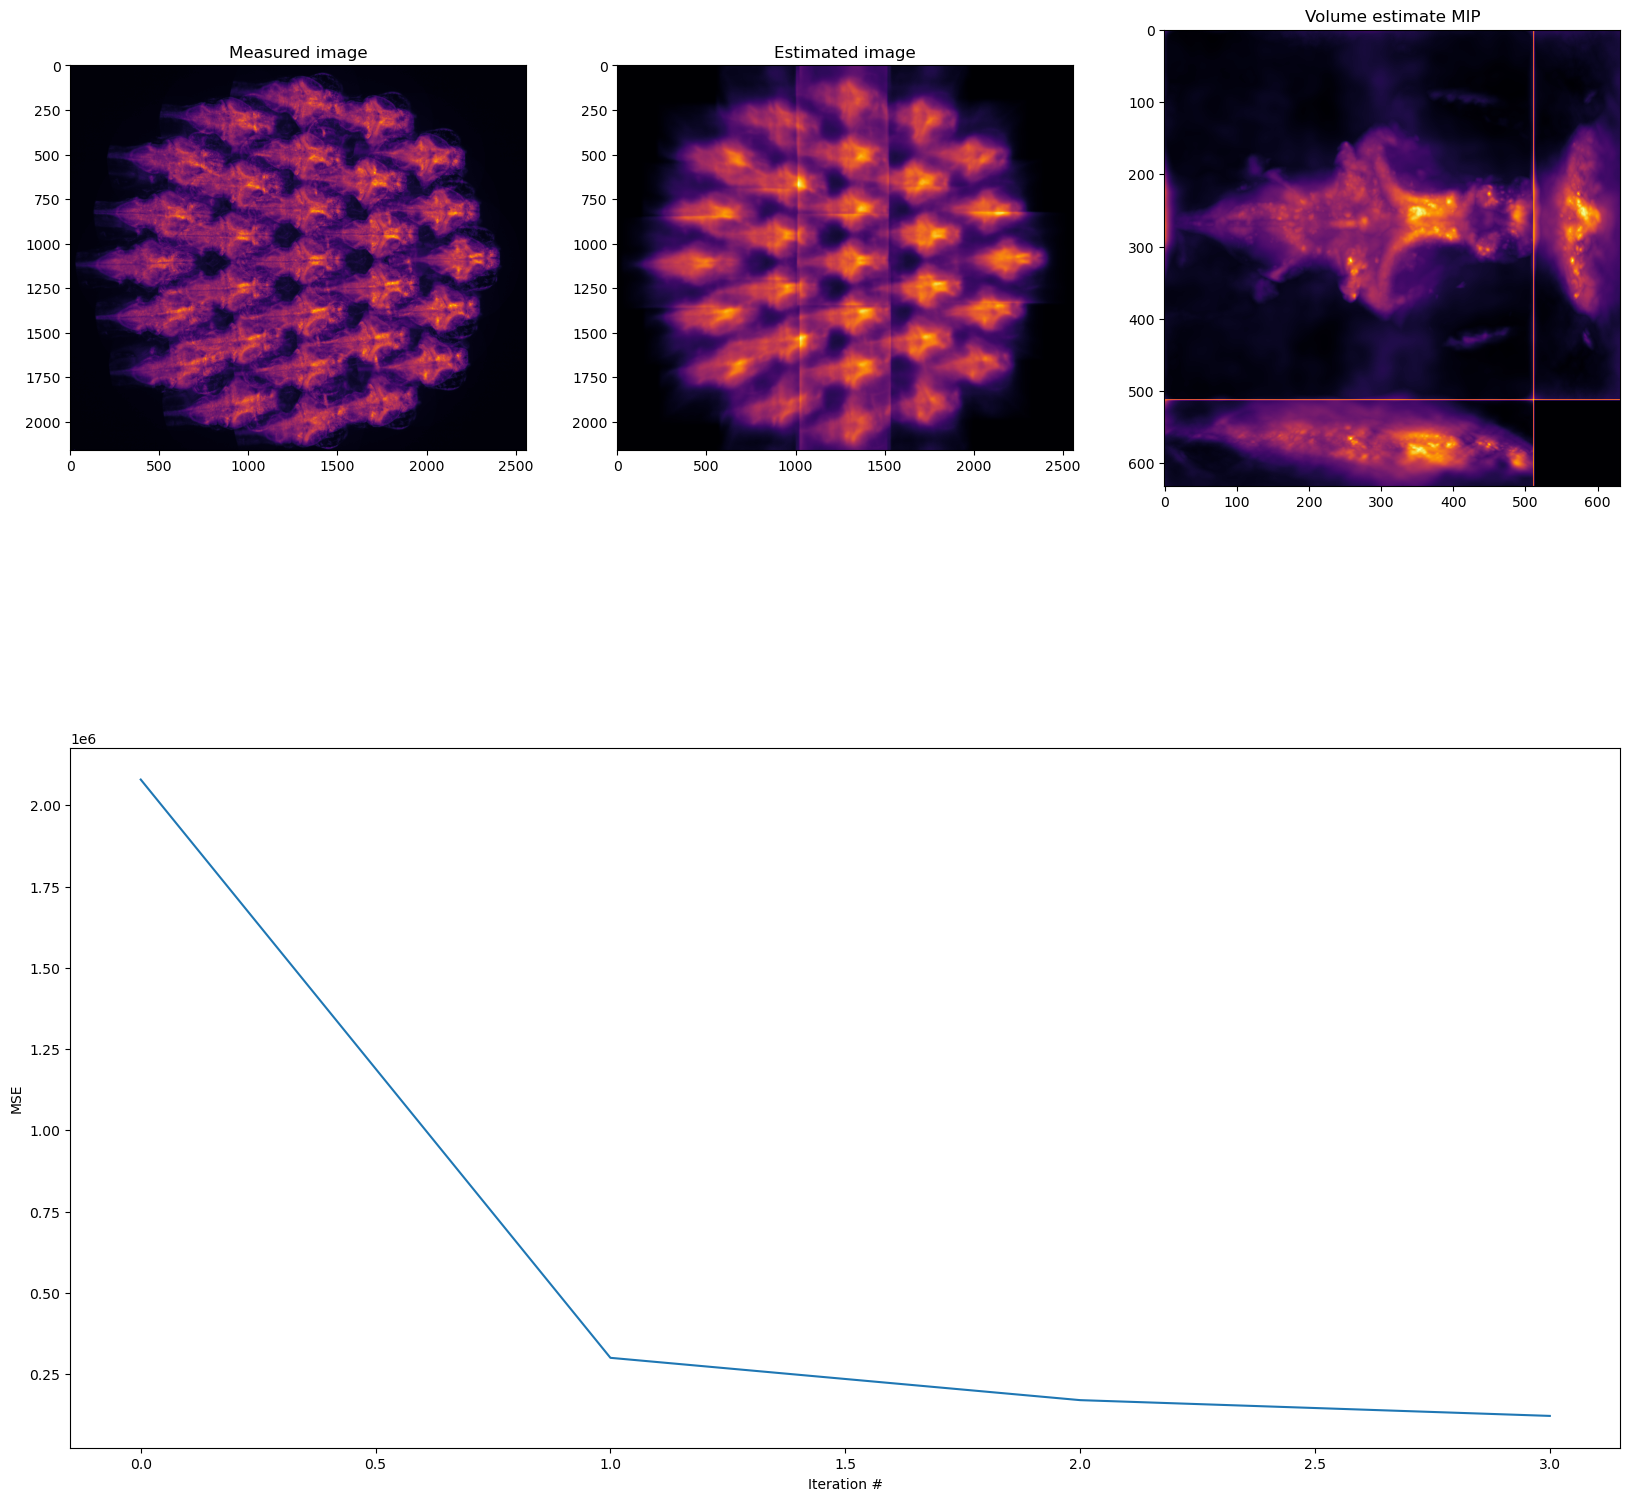

Recon. iteration:  40%|████      | 4/10 [01:57<02:56, 29.44s/it]

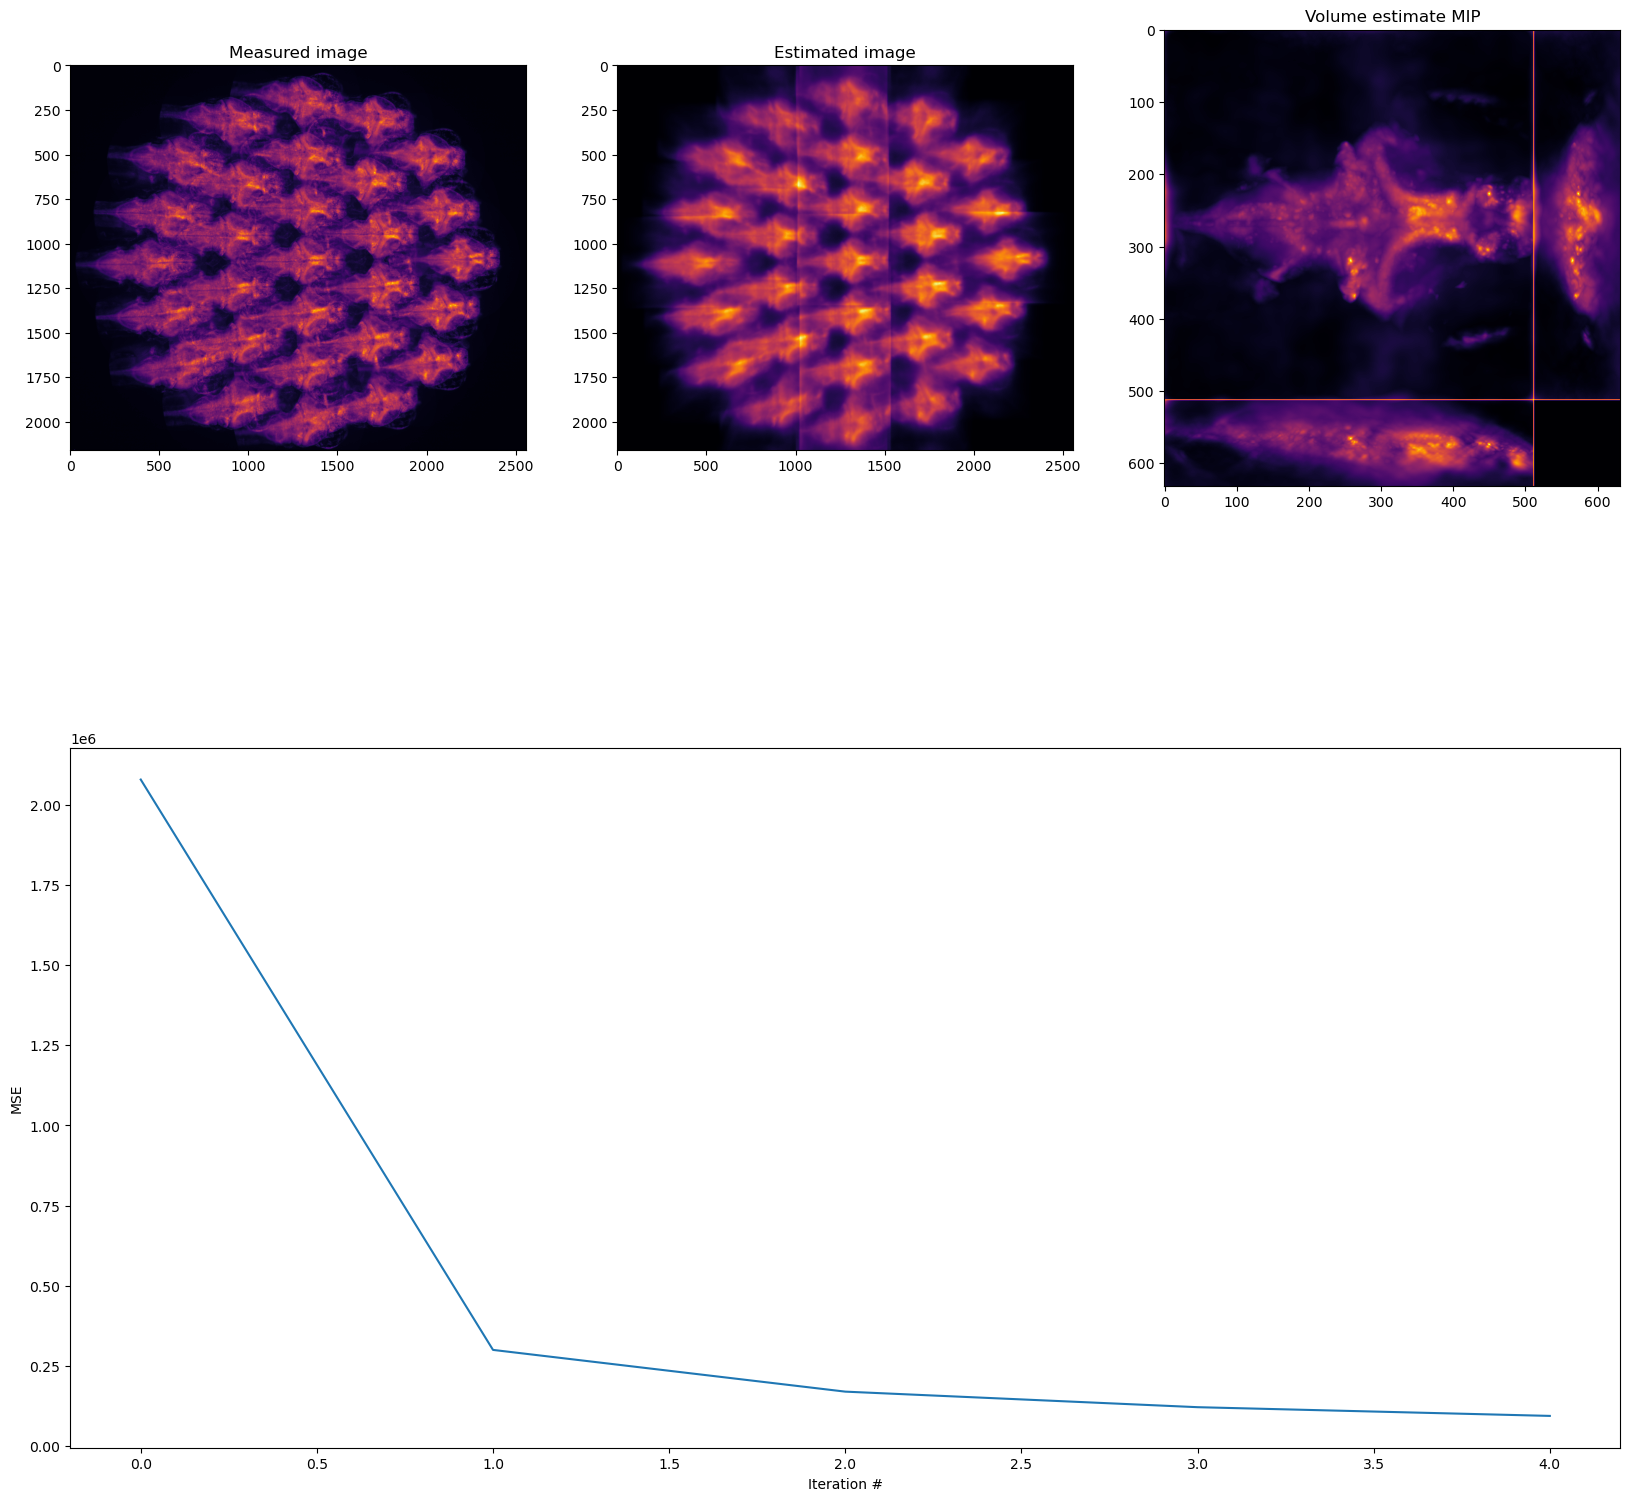

Recon. iteration:  50%|█████     | 5/10 [02:27<02:27, 29.50s/it]

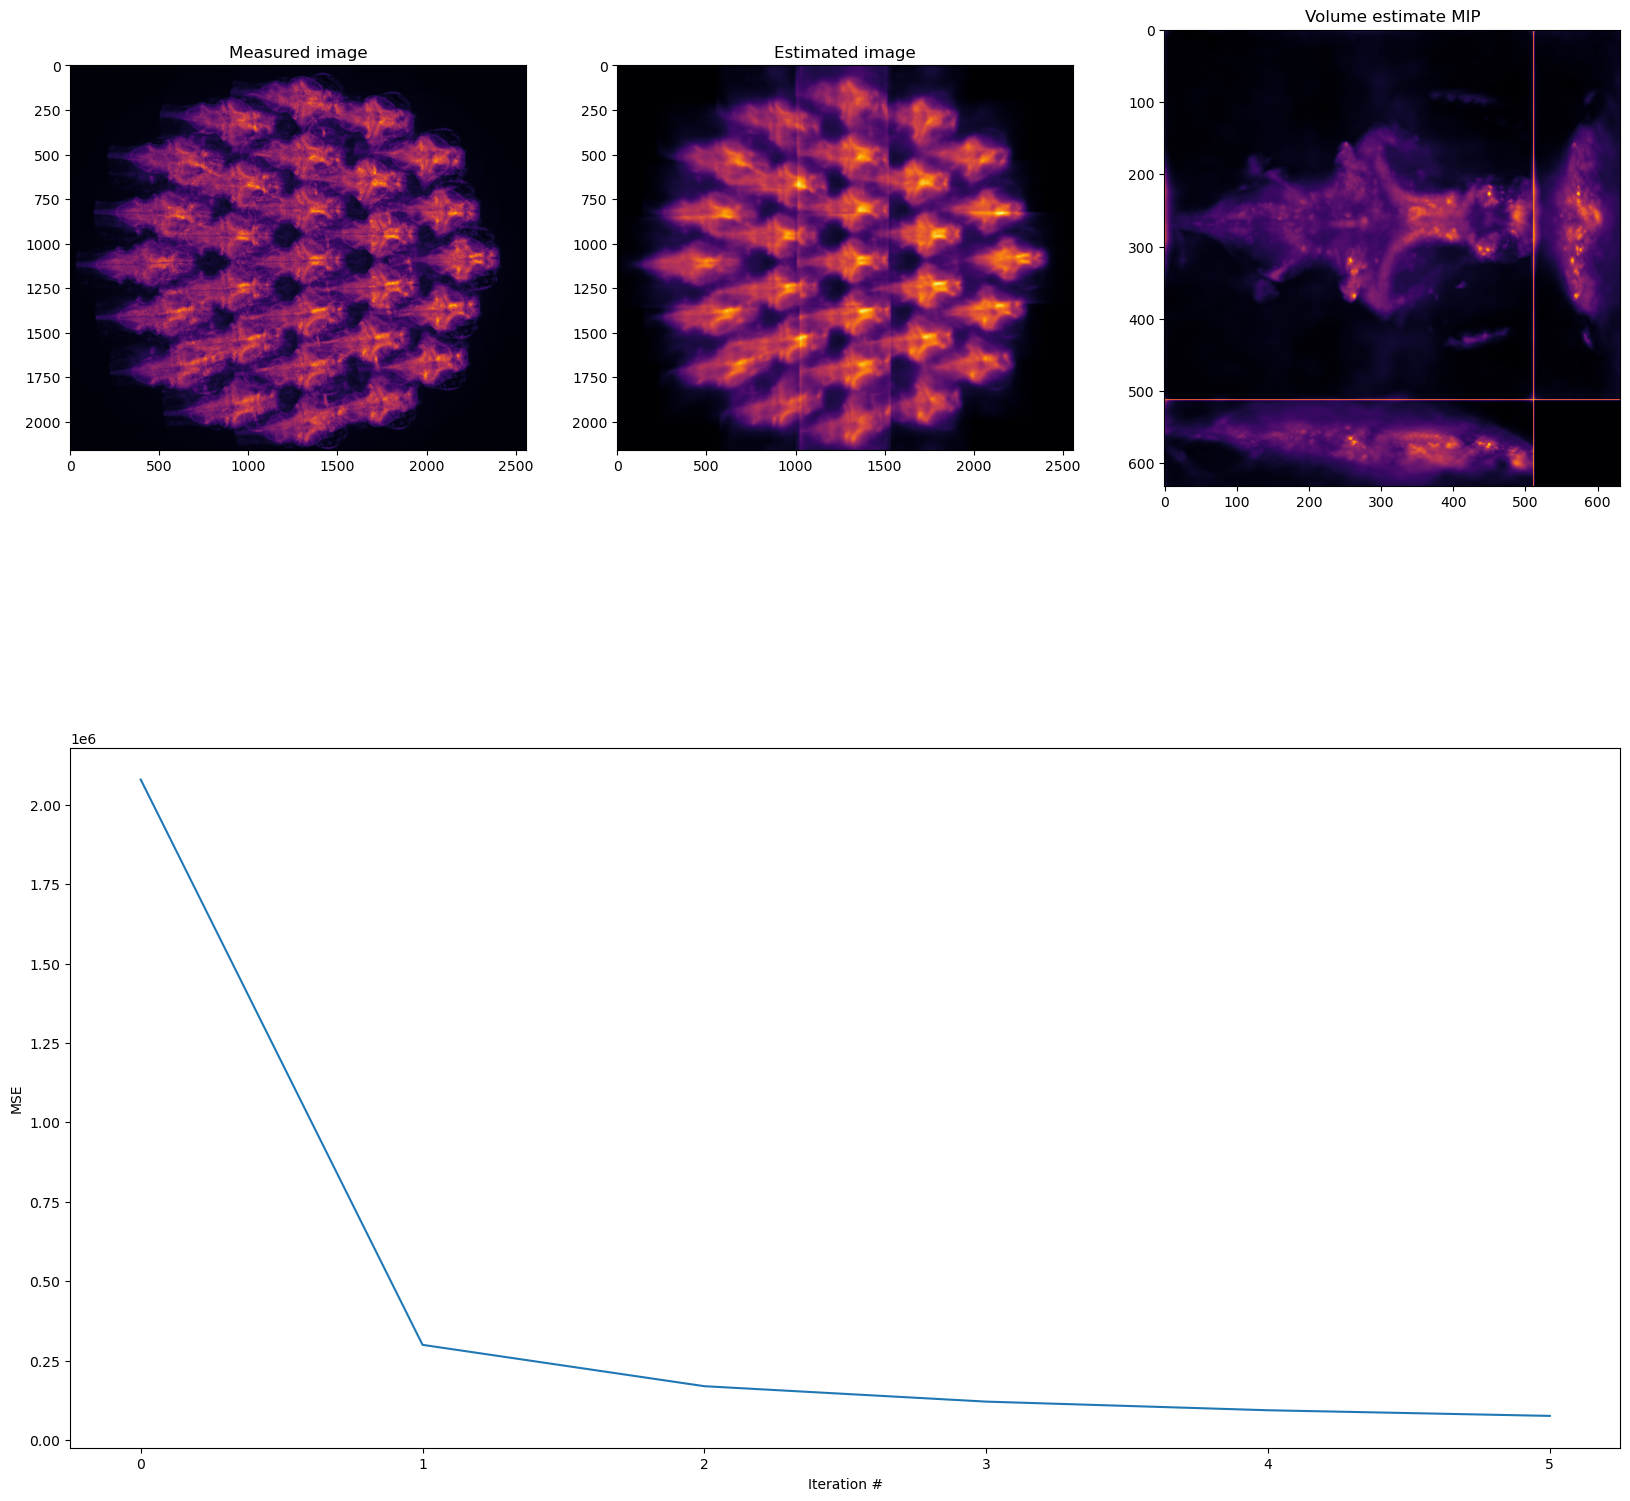

Recon. iteration:  60%|██████    | 6/10 [02:57<01:58, 29.58s/it]

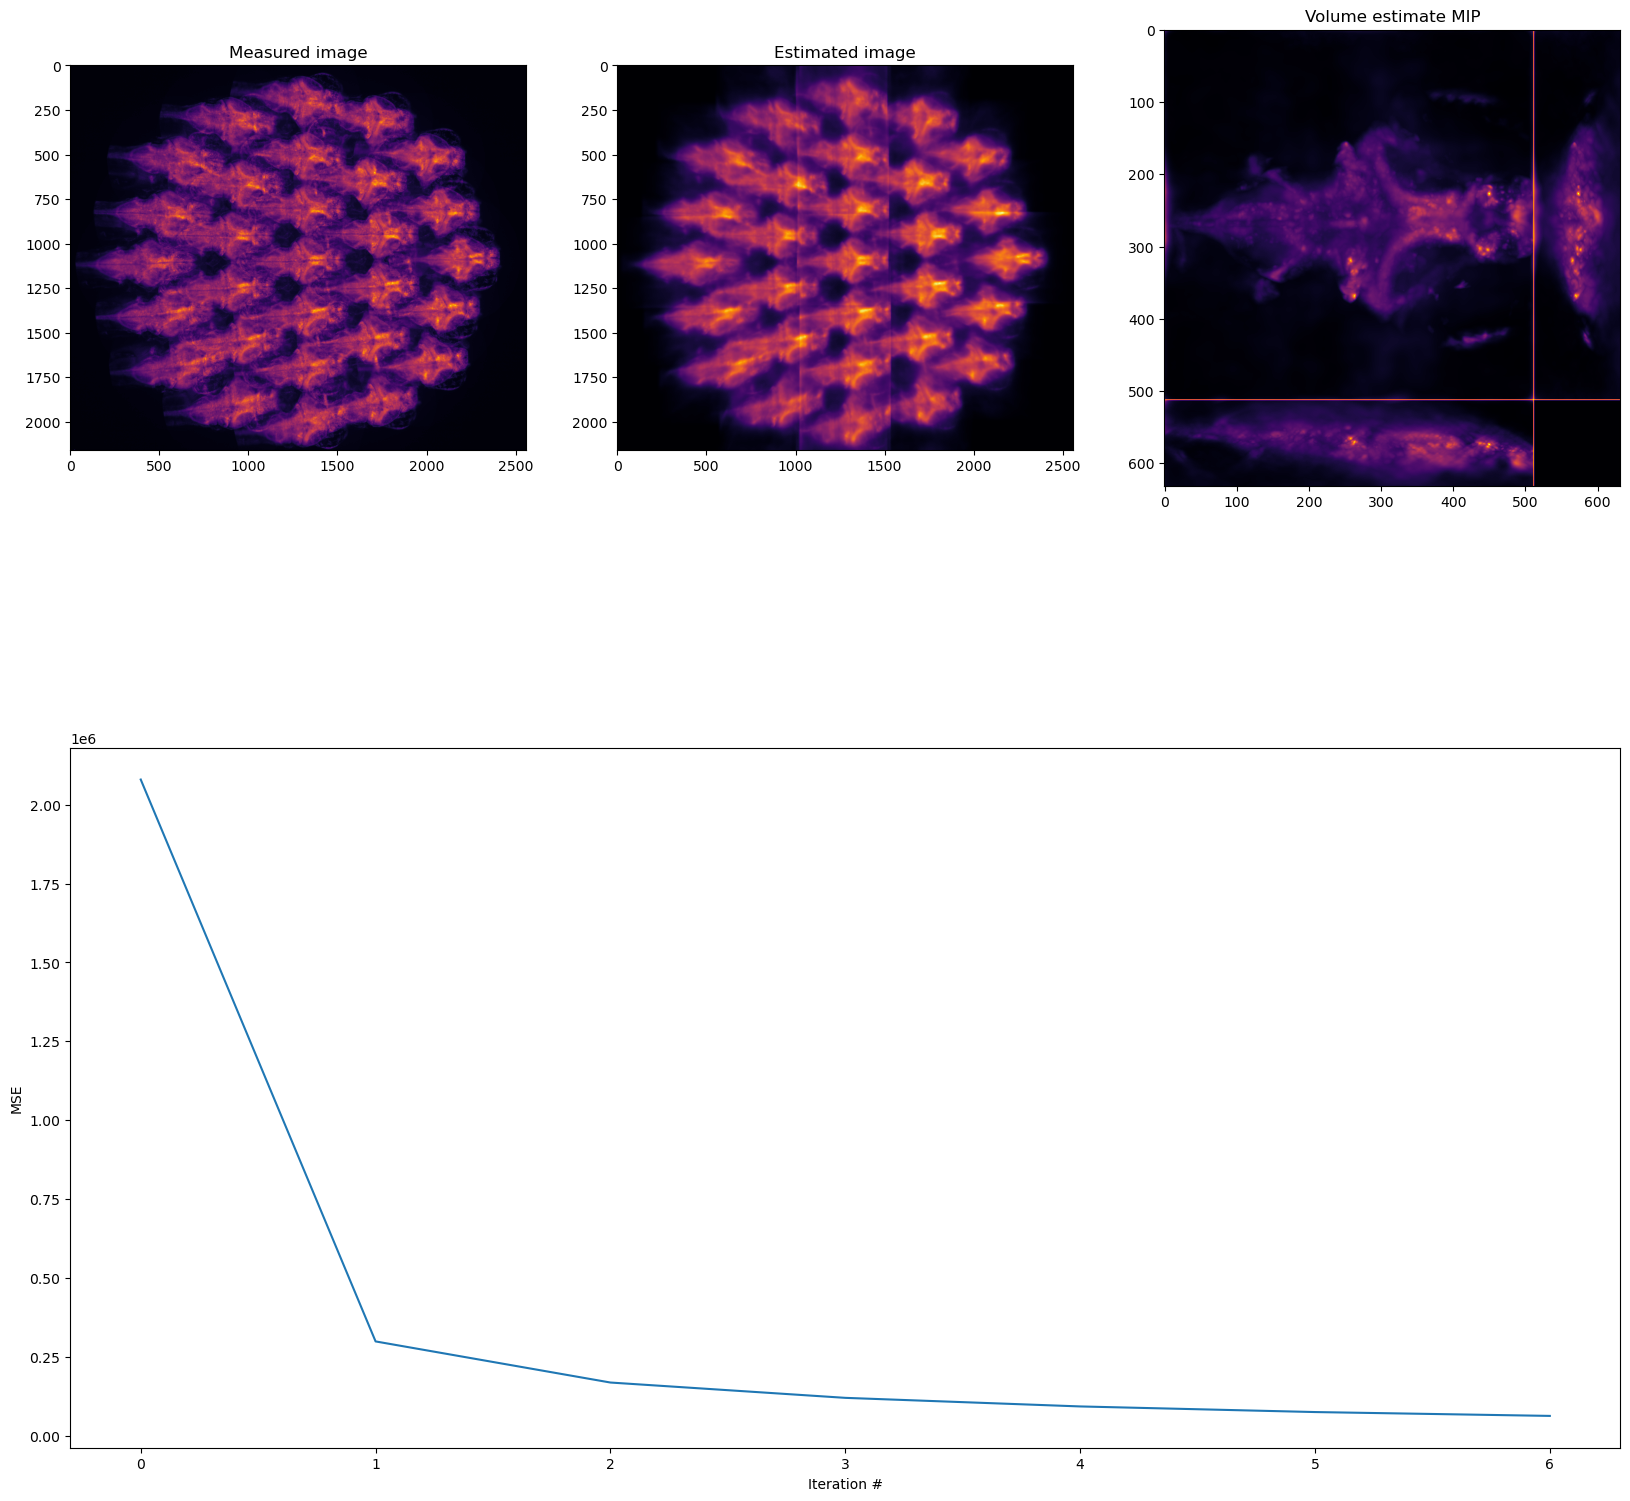

Recon. iteration:  70%|███████   | 7/10 [03:27<01:29, 29.77s/it]

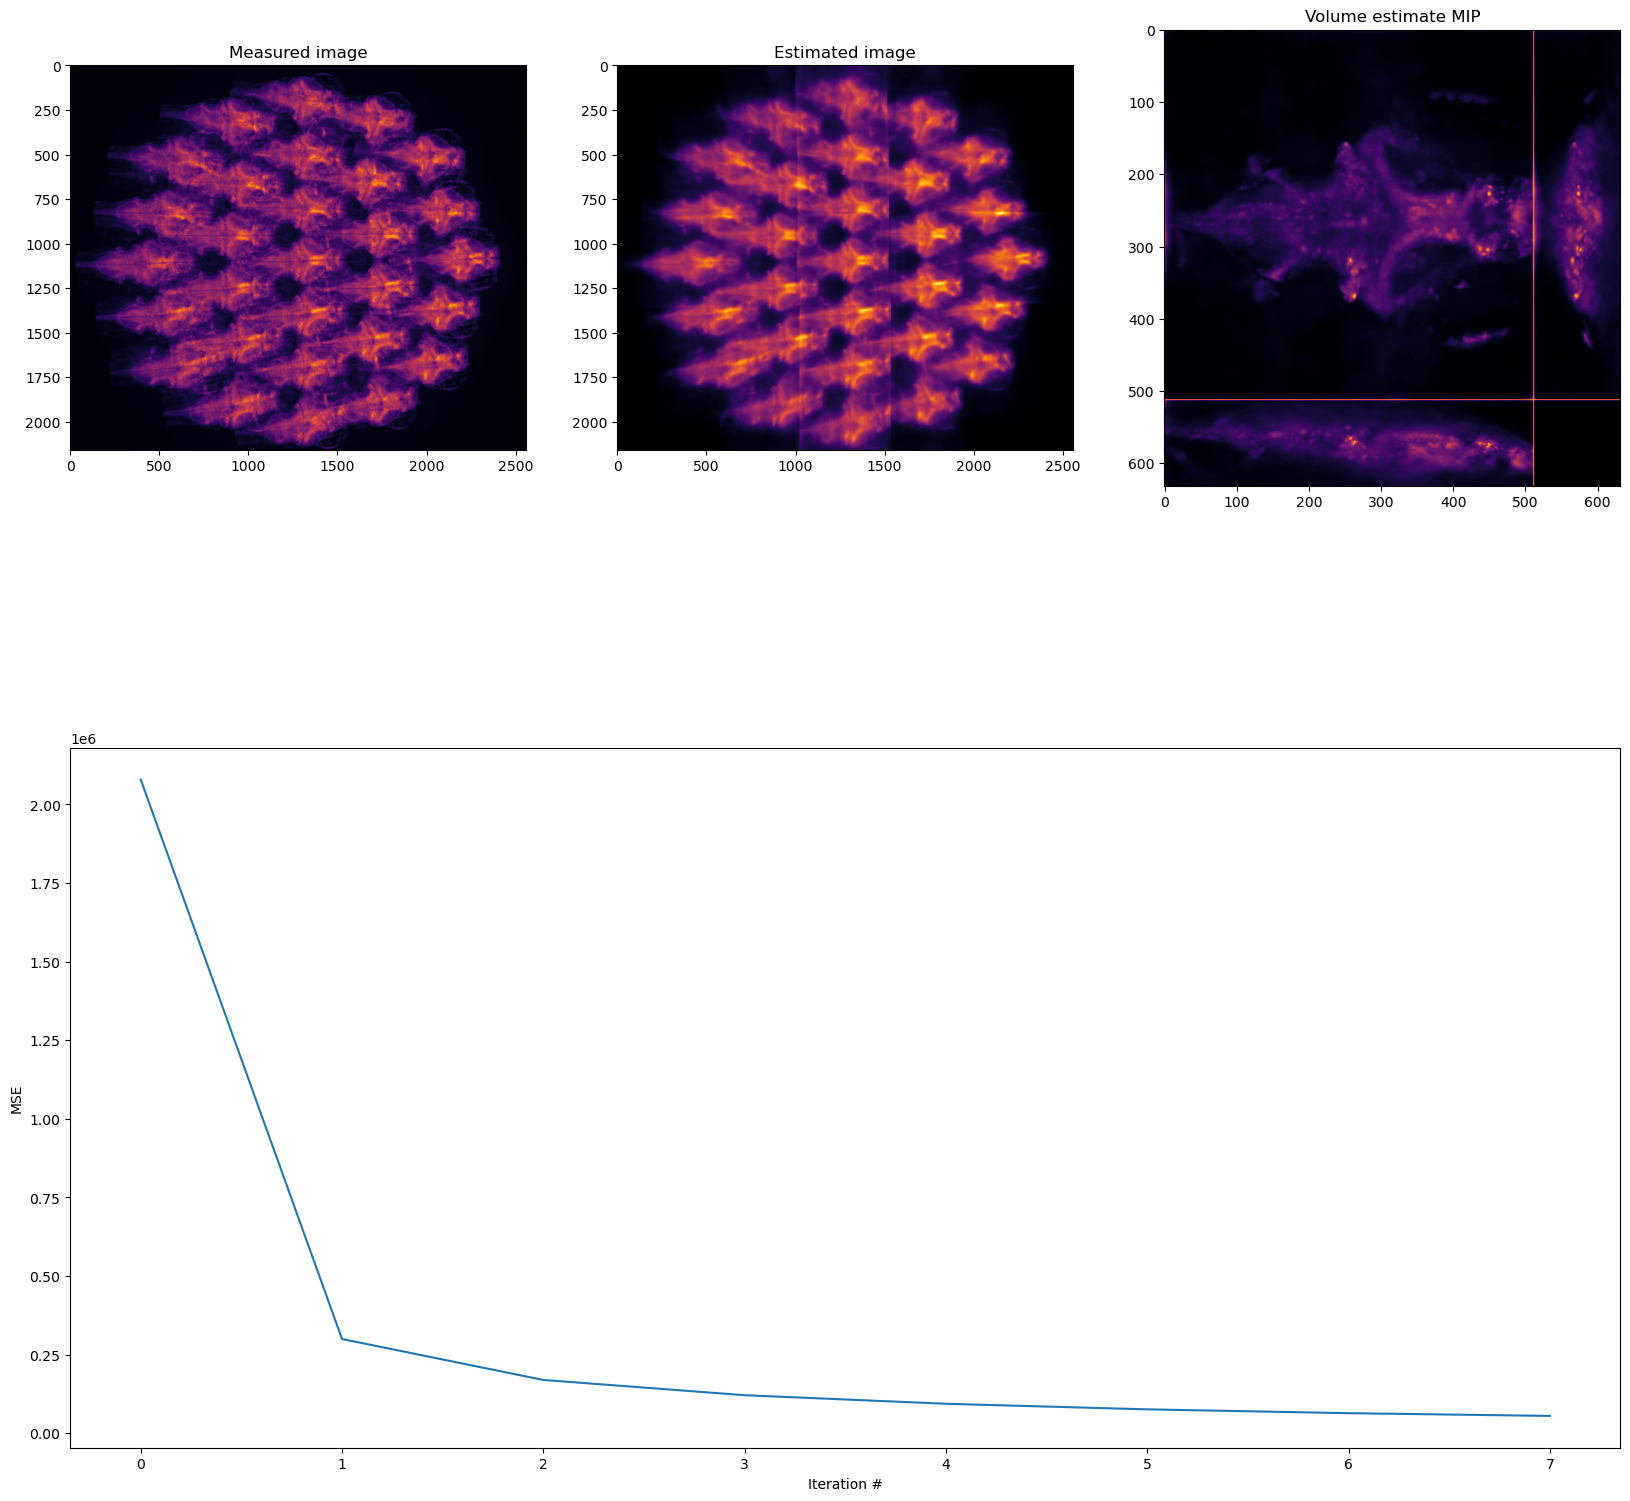

Recon. iteration:  80%|████████  | 8/10 [03:56<00:59, 29.78s/it]

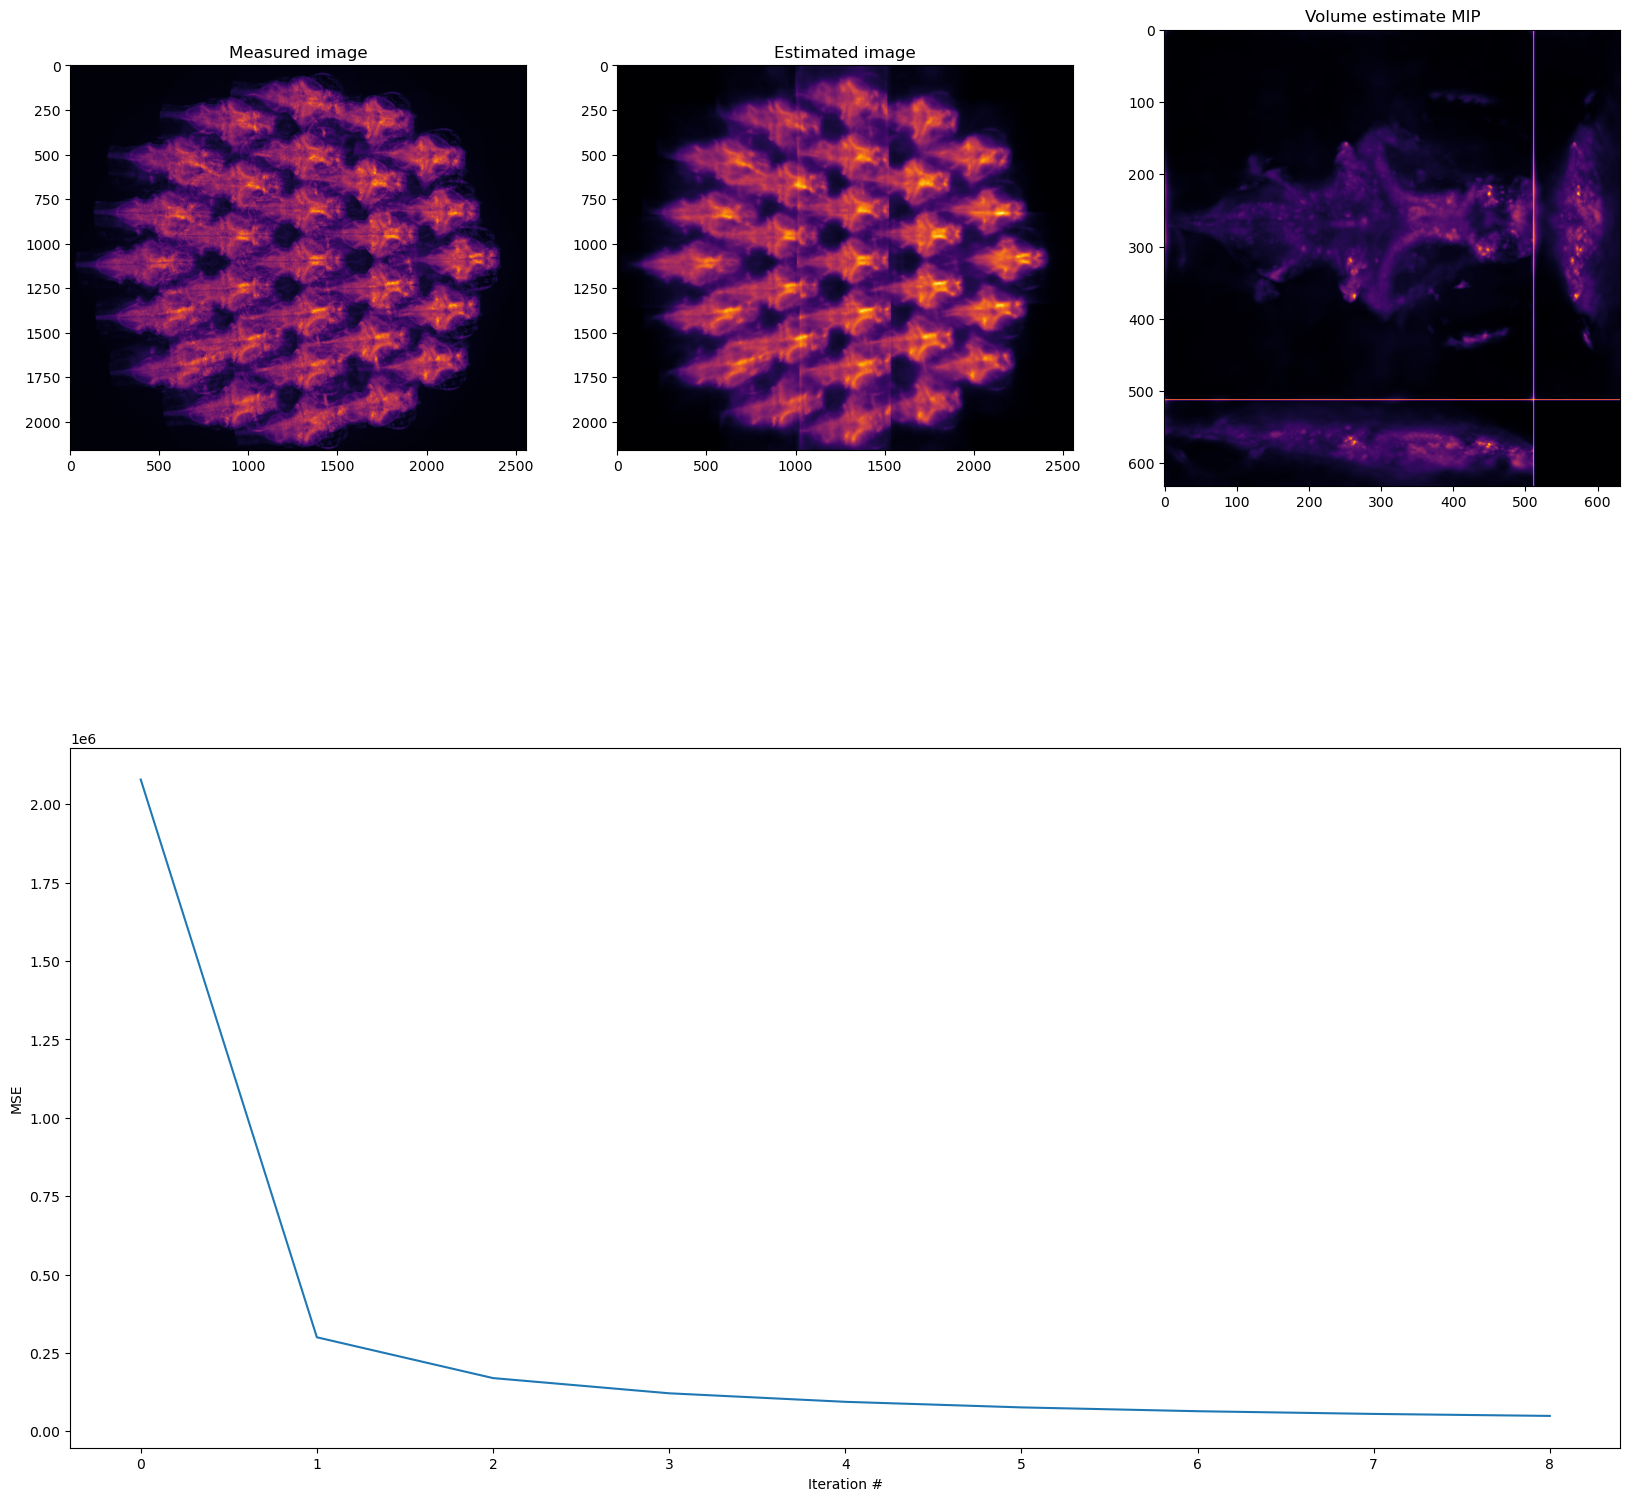

Recon. iteration: 100%|██████████| 10/10 [04:56<00:00, 29.62s/it]


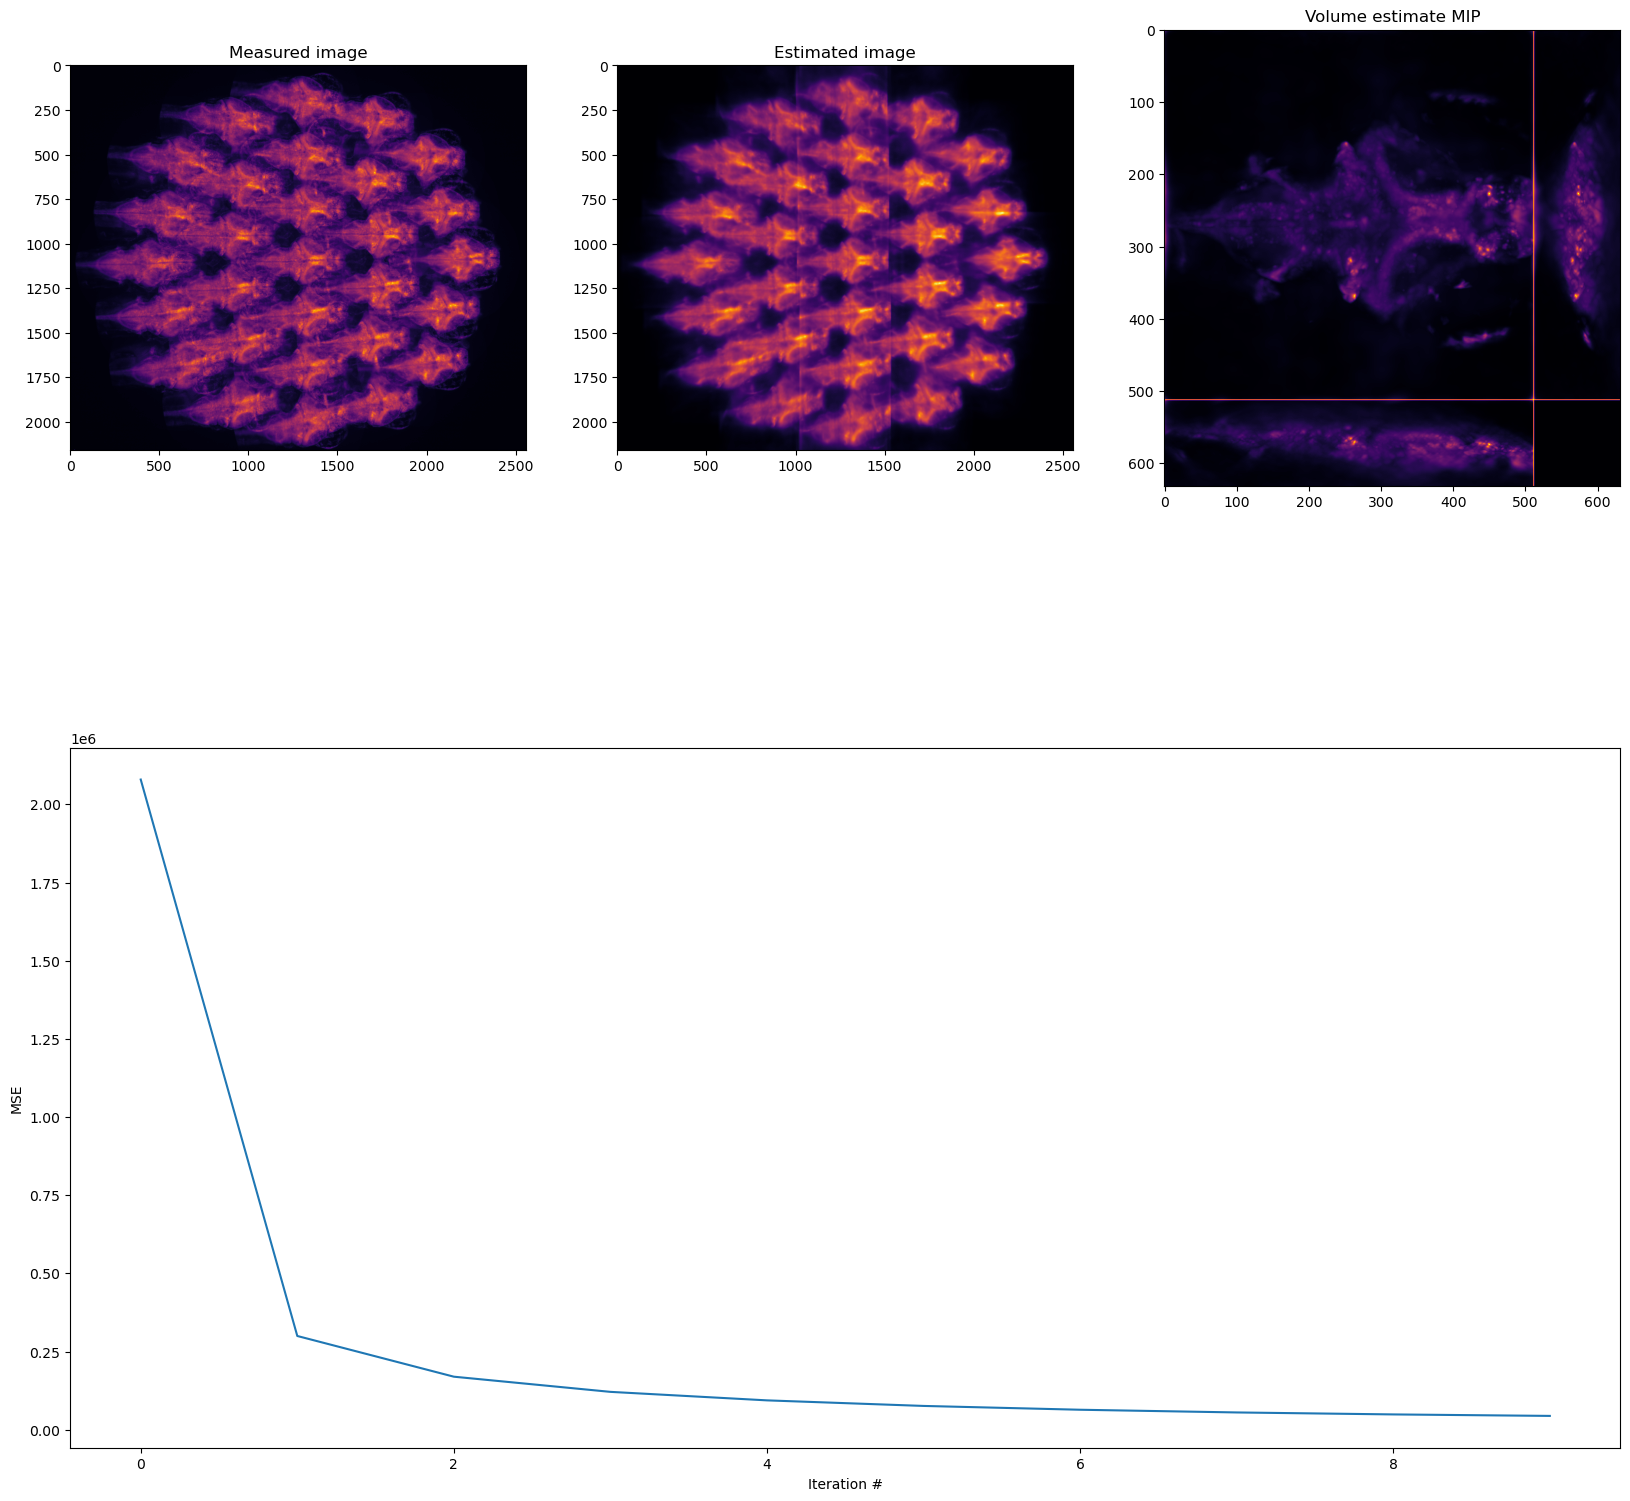

In [10]:
# Prepare plotting
plt.subplots(2, 3)
colormap = 'inferno'

# Store loss
loss = []
# Initial guess for the reconstruction
curr_volume = np.ones(volume_shape)

# Main loop for Deconvolution
for n_it in tqdm(range(n_iterations), "Recon. iteration"):
    
    # Forward Project
    curr_img_estimate = forward(curr_volume, otf, pad_vol)

    # Compute update with selected method
    if loss_function == 'GD':
        new_volume = compute_volume_update_GD(curr_volume, measured_image, curr_img_estimate, otf_t, pad_vol, learning_rate=learning_rate)
    elif loss_function == 'RL':
        new_volume = compute_volume_update_MLEM(curr_volume, measured_image, curr_img_estimate, otf_t, pad_vol)
    else:
        raise NotImplementedError

    # Update volume
    curr_volume = new_volume

    # Compute the loss
    loss.append(MSE(measured_image, curr_img_estimate))

    # Show results
    plt.subplot(2,3,1)
    plt.imshow(measured_image, cmap=colormap)
    plt.title('Measured image')
    
    plt.subplot(2,3,2)
    plt.imshow(curr_img_estimate, cmap=colormap)
    plt.title('Estimated image')

    plt.subplot(2,3,3)
    plt.imshow(MIP(np.transpose(curr_volume, (1,2,0))), cmap=colormap)
    plt.title('Volume estimate MIP')

    ax = plt.subplot(2,1,2)
    ax.clear()
    plt.plot(loss)
    plt.ylabel('MSE')
    plt.xlabel('Iteration #')

    time.sleep(0.1)
    if n_it < n_iterations-1:
        plt.show()
plt.savefig(f'{data_path}/results/recon_img_{loss_function}_loss__{img_ix_to_use}_it_{n_it}.pdf')